In [ ]:
from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()

Saving train_strokes.csv to train_strokes.csv


Saving cardio_train.csv to cardio_train.csv


In [ ]:
import pandas as pd

df_stroke=pd.read_csv('train_strokes.csv')
df_cardio=pd.read_csv('cardio_train.csv',sep=';')

In [ ]:
df_cardio=df_cardio.drop('id',axis=1)
df_cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
print('샘플 수:',df_cardio.shape[0])
df_cardio.isna().sum()

샘플 수: 70000


age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [ ]:
df_stroke=df_stroke.drop('id',axis=1)
df_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [ ]:
#bmi에서의 결측치 샘플을 drop함(정확한 정보를 바탕으로 예측하기 위해 제거)
print('샘플 수:',df_stroke.shape[0])
print(df_stroke.isna().sum())
df_stroke=df_stroke[~(df_stroke['bmi'].isna())]
print('bmi 결측치 제거 후 샘플 수:',df_stroke.shape[0])

샘플 수: 43400
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64
bmi 결측치 제거 후 샘플 수: 41938


In [ ]:
print('smoking_status 특성에 대한 target특성 클래스 분포도')
print(df_stroke[df_stroke['smoking_status'].isna()]['stroke'].value_counts(True))

smoking_status 특성에 대한 target특성 클래스 분포도
0    0.992616
1    0.007384
Name: stroke, dtype: float64


결측치 샘플들에서의 target특성에 대한 클래스 분포도는 negative로 편중되 있는것을 확인되어 결측치는 'never smoked'으로 채우는 것으로 결정하였습니다.

In [ ]:
Other_list=df_stroke[df_stroke['gender']=='Other']
df_stroke=df_stroke.drop(Other_list.index)
Other_list

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2914,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0
19748,Other,39.0,0,0,Yes,Govt_job,Urban,95.59,32.0,formerly smoked,0
21041,Other,19.0,0,0,No,Private,Rural,75.76,32.2,formerly smoked,0
21192,Other,49.0,0,0,Yes,Private,Urban,94.88,37.2,never smoked,0
24252,Other,51.0,0,0,Yes,Private,Rural,91.75,32.2,formerly smoked,0
26199,Other,10.0,0,0,No,children,Rural,72.05,21.2,formerly smoked,0
40768,Other,11.0,0,0,No,children,Urban,101.30,18.1,formerly smoked,0


gender특성에서 Other로 설정되어 있는 샘플의 개수는 7개 이므로 이 샘플을 제거합니다.

In [ ]:
df_stroke[df_stroke['stroke']==1]['heart_disease'].value_counts(True)

0    0.77605
1    0.22395
Name: heart_disease, dtype: float64

In [ ]:
#뇌졸중 특성에 있는 특성과 일치화를 위해 특성공학 진행
def engineering_cardio(df):
  df['age']=round(df['age']/365,1)
  df['bmi']=round(df['weight']/((df['height']/100)**2),1)
  df['hypertension']=((df['ap_hi']>=140) | (df['ap_lo']>=90)).astype(int)

  df=df.drop(['weight','height','ap_hi','ap_lo'],axis=1)

  return df

#심장질환 특성과의 일치화를 위해 전처리 진행
def engineering_stroke(df):

  avg_glucose_level=[]
  for i in range(len(df['avg_glucose_level'])):
    if df['avg_glucose_level'].iloc[i]<140:
      avg_glucose_level.append(1)
    elif df['avg_glucose_level'].iloc[i]<=200:
      avg_glucose_level.append(2)
    else:
      avg_glucose_level.append(3)

  df['gluc']=avg_glucose_level

  for i in df[df['smoking_status'].isna()]['smoking_status'].index:
    df.loc[i,'smoking_status']='never smoked'

  smoking_status=[]
  for i in range(len(df['smoking_status'])):
    if df['smoking_status'].iloc[i]=='never smoked':
      smoking_status.append(0)
    else:
      smoking_status.append(1)

  df['smoke']=smoking_status

  gender=[]
  for i in range(len(df['gender'])):
    if df['gender'].iloc[i]=='Female':
      gender.append(1)
    elif df['gender'].iloc[i] == 'Male':
      gender.append(2)
  df['gender']=gender

  df=df.drop(['smoking_status','avg_glucose_level','ever_married','work_type','Residence_type'],axis=1)

  return df

동일한 특성을 사용하여 각각의 질병을 예측하여 비교할수 있도록 특성공학 및 전처리를 진행해 주었습니다.

In [ ]:
df_stroke=engineering_stroke(df_stroke)
df_cardio=engineering_cardio(df_cardio)
df_stroke

,gender,age,hypertension,heart_disease,bmi,stroke,gluc,smoke
0,2,3.0,0,0,18.0,0,1,0
1,2,58.0,1,0,39.2,0,1,0
2,1,8.0,0,0,17.6,0,1,0
3,1,70.0,0,0,35.9,0,1,1
4,2,14.0,0,0,19.1,0,2,0
...,...,...,...,...,...,...,...,...
43395,1,10.0,0,0,20.4,0,1,0
43396,1,56.0,0,0,55.4,0,3,1
43397,1,82.0,1,0,28.9,0,1,1
43398,2,40.0,0,0,33.2,0,1,0


In [ ]:
df_cardio

,age,gender,cholesterol,gluc,smoke,alco,active,cardio,bmi,hypertension
0,50.4,2,1,1,0,0,1,0,22.0,0
1,55.4,1,3,1,0,0,1,1,34.9,1
2,51.7,1,3,1,0,0,0,1,23.5,0
3,48.3,2,1,1,0,0,1,1,28.7,1
4,47.9,1,1,1,0,0,0,0,23.0,0
...,...,...,...,...,...,...,...,...,...,...
69995,52.7,2,1,1,1,0,1,0,26.9,0
69996,61.9,1,2,2,0,0,1,1,50.5,1
69997,52.2,2,3,1,0,1,0,1,31.4,1
69998,61.5,1,1,2,0,0,0,1,27.1,0


In [ ]:
from sklearn.model_selection import train_test_split

#모델 학습을 위한 훈련데이터셋과 테스트데이터셋의 분리
train_stroke,test_stroke=train_test_split(df_stroke,test_size=0.2,random_state=2,stratify=df_stroke['stroke'])
train_cardio,test_cardio=train_test_split(df_cardio,test_size=0.2,random_state=2,stratify=df_cardio['cardio'])
print('stroke(train/test):',train_stroke.shape,test_stroke.shape)
print('cardio(train/test):',train_cardio.shape,test_cardio.shape)


stroke(train/test): (33544, 8) (8387, 8)
cardio(train/test): (56000, 10) (14000, 10)


In [ ]:
X_train_stroke=train_stroke.drop('stroke',axis=1)
y_train_stroke=train_stroke['stroke']
X_test_stroke=test_stroke.drop('stroke',axis=1)
y_test_stroke=test_stroke['stroke']

X_train_cardio=train_cardio.drop('cardio',axis=1)
y_train_cardio=train_cardio['cardio']
X_test_cardio=test_cardio.drop('cardio',axis=1)
y_test_cardio=test_cardio['cardio']

In [ ]:
#타겟 데이터의 클래스 분포 확인
print(y_train_stroke.value_counts(True))
print(y_train_cardio.value_counts(True))

0    0.984677
1    0.015323
Name: stroke, dtype: float64
0    0.500304
1    0.499696
Name: cardio, dtype: float64


In [ ]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 3.9 MB/s 


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.metrics import classification_report
#stroke model------------------------------------------------------
class_weight=y_train_stroke.value_counts(True)

model_RF_stroke= make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=2,oob_score=True,n_jobs=-1,class_weight={0:class_weight[0],1:class_weight[1]},criterion='entropy')
)


model_RF_stroke.fit(X_train_stroke,y_train_stroke)
print('---------------------stroke RF model info---------------------')
print(model_RF_stroke.named_steps['randomforestclassifier'].oob_score_)
y_pred=model_RF_stroke.predict(X_test_stroke)
print(classification_report(y_test_stroke, y_pred))

#cardio model----------------------------------------------------
model_RF_cardio= make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=2,oob_score=True,n_jobs=-1,criterion='entropy')
)

model_RF_cardio.fit(X_train_cardio,y_train_cardio)
print('\n\n------------------cardio RF model info--------------------')
print(model_RF_cardio.named_steps['randomforestclassifier'].oob_score_)
y_pred=model_RF_cardio.predict(X_test_cardio)
print(classification_report(y_test_cardio, y_pred))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


---------------------stroke RF model info---------------------
0.9817553064631529
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8258
           1       0.06      0.02      0.02       129

    accuracy                           0.98      8387
   macro avg       0.52      0.51      0.51      8387
weighted avg       0.97      0.98      0.98      8387



------------------cardio RF model info--------------------
0.6715178571428572
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      7004
           1       0.67      0.68      0.68      6996

    accuracy                           0.68     14000
   macro avg       0.68      0.68      0.68     14000
weighted avg       0.68      0.68      0.68     14000



기본 설정으로 학습된 랜덤포레스트 모델은 클래스편향정보를 부여했지만 훈련데이터에 대해서 완전히 과적합한 모델이 된것을 확인 하였습니다.

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier


#---------------------------stroke model---------------------------

train2_stroke,val_stroke=train_test_split(train_stroke,test_size=0.2,random_state=2,stratify=train_stroke['stroke'])

#xgboost모델에서의 검증용 데이터를 위한 훈련데이터 분할
encoder_stroke=OrdinalEncoder()

X_train2_stroke= encoder_stroke.fit_transform(train2_stroke.drop('stroke',axis=1))
y_train2_stroke=train2_stroke['stroke']
X_val_stroke= encoder_stroke.transform(val_stroke.drop('stroke',axis=1))
y_val_stroke=val_stroke['stroke']



model_XG_stroke=XGBClassifier(n_estimators=300,random_state=2,n_jobs=-1,scale_pos_weight=class_weight[0]/class_weight[1])

eval_set=[(X_train2_stroke,y_train2_stroke),(X_val_stroke,y_val_stroke)]

model_XG_stroke.fit(X_train2_stroke,
                    y_train2_stroke,
                    eval_set=eval_set,
                    early_stopping_rounds=30,
                    eval_metric='auc'
                    )

[0]	validation_0-auc:0.855358	validation_1-auc:0.823559
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.860153	validation_1-auc:0.830803
[2]	validation_0-auc:0.865146	validation_1-auc:0.830354
[3]	validation_0-auc:0.866415	validation_1-auc:0.831334
[4]	validation_0-auc:0.867698	validation_1-auc:0.832535
[5]	validation_0-auc:0.867787	validation_1-auc:0.83247
[6]	validation_0-auc:0.868816	validation_1-auc:0.830062
[7]	validation_0-auc:0.868622	validation_1-auc:0.830695
[8]	validation_0-auc:0.869132	validation_1-auc:0.830904
[9]	validation_0-auc:0.868973	validation_1-auc:0.83071
[10]	validation_0-auc:0.870052	validation_1-auc:0.831483
[11]	validation_0-auc:0.870514	validation_1-auc:0.833365
[12]	validation_0-auc:0.870531	validation_1-auc:0.832999
[13]	validation_0-auc:0.870936	validation_1-auc:0.833855
[14]	validation_0-auc:0.870978	validation_1-auc:0.833347


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=64.26070038910505,
              seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
#-------------------------cardio model---------------------------
train2_cardio,val_cardio=train_test_split(train_cardio,test_size=0.2,random_state=2,stratify=train_cardio['cardio'])

#xgboost모델에서의 검증용 데이터를 위한 훈련데이터 분할
encoder_cardio=OrdinalEncoder()

X_train2_cardio= encoder_cardio.fit_transform(train2_cardio.drop('cardio',axis=1))
y_train2_cardio=train2_cardio['cardio']
X_val_cardio= encoder_cardio.transform(val_cardio.drop('cardio',axis=1))
y_val_cardio=val_cardio['cardio']



model_XG_cardio=XGBClassifier(n_estimators=300,random_state=2,n_jobs=-1)

eval_set=[(X_train2_cardio,y_train2_cardio),(X_val_cardio,y_val_cardio)]

model_XG_cardio.fit(X_train2_cardio,
                    y_train2_cardio,
                    eval_set=eval_set,
                    early_stopping_rounds=30,
                    eval_metric='auc'
                    )

[0]	validation_0-auc:0.760761	validation_1-auc:0.760122
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.761644	validation_1-auc:0.761311
[2]	validation_0-auc:0.76474	validation_1-auc:0.763792
[3]	validation_0-auc:0.770348	validation_1-auc:0.769252
[4]	validation_0-auc:0.770189	validation_1-auc:0.769473
[5]	validation_0-auc:0.770862	validation_1-auc:0.769937
[6]	validation_0-auc:0.772871	validation_1-auc:0.771738
[7]	validation_0-auc:0.775396	validation_1-auc:0.773398
[8]	validation_0-auc:0.775422	validation_1-auc:0.773424
[9]	validation_0-auc:0.777048	validation_1-auc:0.774942
[10]	validation_0-auc:0.777058	validation_1-auc:0.774811
[11]	validation_0-auc:0.777709	validation_1-auc:0.775216
[12]	validation_0-auc:0.778015	validation_1-auc:0.775547
[13]	validation_0-auc:0.778504	validation_1-auc:0.775947
[14]	validation_0-auc:0.77867	validation_1-auc:0.776121


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#---------------------------strok model---------------------------
print('---------------------stroke XGB model info---------------------')
y_pred=model_XG_stroke.predict(encoder_stroke.transform(X_test_stroke))
print(classification_report(y_test_stroke, y_pred))

#-------------------------cardio model---------------------------
print('\n\n------------------cardio XGB model info--------------------')
y_pred=model_XG_cardio.predict(encoder_cardio.transform(X_test_cardio))
print(classification_report(y_test_cardio, y_pred))

---------------------stroke XGB model info---------------------
              precision    recall  f1-score   support

           0       1.00      0.76      0.87      8258
           1       0.05      0.81      0.10       129

    accuracy                           0.77      8387
   macro avg       0.52      0.79      0.48      8387
weighted avg       0.98      0.77      0.85      8387



------------------cardio XGB model info--------------------
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      7004
           1       0.75      0.69      0.72      6996

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



XGBoost 모델의 경우 성능지표로 auc를 사용하여 탐색을 진행 했으며 랜덤포레스트 모델에서 보다 더 좋은 성능을 가진 모델을 얻을수 있었습니다.

CV를 통하여 성능이 개선된 모델의 탐색을 진행했습니다.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#---------------------------stroke model---------------------------
dists={
    'max_depth':[2,3,4,5],
    'learning_rate':[0.03,0.05,0.08,0.1,0.12,0.15,0.2],
    'colsample_bytree':[0.5,0.75,0.9,1]
}

clf=RandomizedSearchCV(
    model_XG_stroke,  
    param_distributions=dists,
    n_iter=200,
    cv=4,
    scoring='recall', 
    verbose=1,
    n_jobs=-1
)
eval_set=[(X_train2_stroke.to_numpy(),y_train2_stroke),(X_val_stroke.to_numpy(),y_val_stroke)]

clf.fit(X_train2_stroke.to_numpy(),
        y_train2_stroke,
        eval_set=eval_set,
        early_stopping_rounds=30,
        eval_metric='auc'
        )

print('best_score:',clf.best_score_)
clf.best_params_

Fitting 4 folds for each of 112 candidates, totalling 448 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 112 is smaller than n_iter=200. Running 112 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min


[0]	validation_0-auc:0.842853	validation_1-auc:0.801058
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.


[Parallel(n_jobs=-1)]: Done 448 out of 448 | elapsed:  6.1min finished


[1]	validation_0-auc:0.847812	validation_1-auc:0.809272
[2]	validation_0-auc:0.851016	validation_1-auc:0.817492
[3]	validation_0-auc:0.851016	validation_1-auc:0.817492
[4]	validation_0-auc:0.851016	validation_1-auc:0.817492
[5]	validation_0-auc:0.851016	validation_1-auc:0.817492
[6]	validation_0-auc:0.851848	validation_1-auc:0.819005
[7]	validation_0-auc:0.851848	validation_1-auc:0.819005
[8]	validation_0-auc:0.851848	validation_1-auc:0.819005
[9]	validation_0-auc:0.852298	validation_1-auc:0.818844
[10]	validation_0-auc:0.852298	validation_1-auc:0.818844
[11]	validation_0-auc:0.854062	validation_1-auc:0.819395
[12]	validation_0-auc:0.854465	validation_1-auc:0.821018
[13]	validation_0-auc:0.862726	validation_1-auc:0.830249
[14]	validation_0-auc:0.86273	validation_1-auc:0.83027
[15]	validation_0-auc:0.86273	validation_1-auc:0.83027
[16]	validation_0-auc:0.862128	validation_1-auc:0.830161
[17]	validation_0-auc:0.862726	validation_1-auc:0.830249
[18]	validation_0-auc:0.862729	validation_1-

{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 2}

In [ ]:
#-------------------------cardio model---------------------------
dists={
    'max_depth':[2,3,4,5],
    'learning_rate':[0.03,0.05,0.08,0.1,0.12,0.15],
    'colsample_bytree':[0.5,0.6,0.75,0.9,1]
}

clf2=RandomizedSearchCV(
    model_XG_cardio,  
    param_distributions=dists,
    n_iter=50,
    cv=4,
    scoring='f1', 
    verbose=1,
    n_jobs=-1
)

eval_set=[(X_train2_cardio.to_numpy(),y_train2_cardio),(X_val_cardio.to_numpy(),y_val_cardio)]

clf2.fit(X_train2_cardio.to_numpy(),
        y_train2_cardio,
        eval_set=eval_set,
        early_stopping_rounds=30,
        eval_metric='auc'
        )

print('best_score:',clf2.best_score_)
clf2.best_params_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.3min


[0]	validation_0-auc:0.738522	validation_1-auc:0.736441


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 10.4min finished


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.772289	validation_1-auc:0.76812
[2]	validation_0-auc:0.773615	validation_1-auc:0.768524
[3]	validation_0-auc:0.773209	validation_1-auc:0.768712
[4]	validation_0-auc:0.780126	validation_1-auc:0.776262
[5]	validation_0-auc:0.782126	validation_1-auc:0.777879
[6]	validation_0-auc:0.783628	validation_1-auc:0.779162
[7]	validation_0-auc:0.783427	validation_1-auc:0.778802
[8]	validation_0-auc:0.783528	validation_1-auc:0.779615
[9]	validation_0-auc:0.783859	validation_1-auc:0.779787
[10]	validation_0-auc:0.784707	validation_1-auc:0.780335
[11]	validation_0-auc:0.784348	validation_1-auc:0.780503
[12]	validation_0-auc:0.784939	validation_1-auc:0.780694
[13]	validation_0-auc:0.785159	validation_1-auc:0.78074
[14]	validation_0-auc:0.785195	validation_1-auc:0.78078
[15]	validation_0-auc:0.785495	validation_1-auc:0.781142


{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 5}

In [ ]:
#---------------------------strok model---------------------------
best_model_XG_stroke=clf.best_estimator_
print('---------------------stroke XGB model info---------------------')
y_pred=best_model_XG_stroke.predict(encoder_stroke.transform(X_test_stroke).to_numpy())
print(classification_report(y_test_stroke, y_pred))

#-------------------------cardio model---------------------------
best_model_XG_cardio=clf2.best_estimator_
print('\n\n------------------cardio XGB model info--------------------')
y_pred=best_model_XG_cardio.predict(encoder_cardio.transform(X_test_cardio).to_numpy())
print(classification_report(y_test_cardio, y_pred))

---------------------stroke XGB model info---------------------
              precision    recall  f1-score   support

           0       1.00      0.69      0.82      8258
           1       0.04      0.85      0.08       129

    accuracy                           0.70      8387
   macro avg       0.52      0.77      0.45      8387
weighted avg       0.98      0.70      0.81      8387



------------------cardio XGB model info--------------------
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      7004
           1       0.75      0.69      0.72      6996

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



모델의 훈련 방식은 auc가 가장 좋은 점수를 받을 때까지 훈련을 진행 하였으며 CV과정에서 재현율(recall)이 가장 높은 모델을 선정하는 방법으로 다음과 같은 성능지표를 얻을수 있었습니다.

negative를 받은 샘플군에서는 99%의 정밀도로 뇌졸중이 일어나지 않았다는 것과 positive군에서는 해당 샘플에서의 true positive에 대한 재현율을 90%까지 높혀 positive로 예측된 샘플군에 대해서는 10명중 1명은 뇌졸중을 앓는 것으로 확인할수 있습니다.

이를바탕으로 해당 모델로 예측된 positive군에 대해서는 뇌졸중 검사를 받는것이 요구되며 negative군에서는 뇌졸중의 위험이 상당한 수준으로 낮다고 판단할수 있습니다.

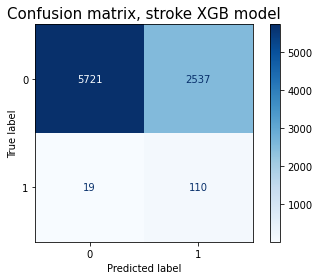

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plot_confusion_matrix(best_model_XG_stroke,
                      encoder_stroke.transform(X_test_stroke).to_numpy(),
                      y_test_stroke,
                      cmap=plt.cm.Blues,ax=ax,
                      values_format = 'd')

plt.title(f'Confusion matrix, stroke XGB model', fontsize=15)
plt.show()

뇌졸중 예측모델에서의 혼돈메트릭스 확인 결과 negative에 대한 예측 정확도가 100%에 가깝게 나왔지만 전체 표본에서의 positive샘플의 양이 압도적으로 적기 때문에 일어난 착시라고 판단할수 있습니다.

실제 뇌졸중을 일으킨 환자의 약15%가 negative로 예측되며, 이는 그 인원에 대한 관리 및 예방을 하지 못하게 되어버리는 것을 말합니다.

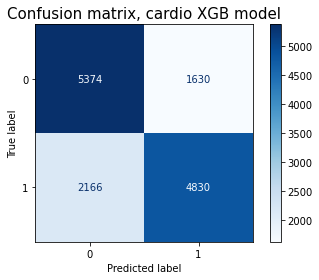

In [ ]:
fig, ax = plt.subplots()
plot_confusion_matrix(best_model_XG_cardio,
                      X_test_cardio.to_numpy(),
                      y_test_cardio,
                      cmap=plt.cm.Blues,ax=ax,
                      values_format = 'd')

plt.title(f'Confusion matrix, cardio XGB model', fontsize=15)
plt.show()

심장질환에 대한 positive와 negative 각각의 예측확율이 비슷한 성능을 보이고 있습니다.

심장질환의 경우 뇌졸중보다 사전예방이 가능한 편이며, 해당 증상이 발병했을 때 뇌졸중의 경우가 더 위중한 결과를 불러 일으킵니다.

그러므로 각각의 모델에 대한 특성관계를 확인하고 모델에 들어가는 특성의 싱크를 맞춘 후,
임계값을 조절하여 심장질환 모델은 정밀도를, 뇌졸중 모델은 재현율을 최대한 끌어올리도록 하겠습니다.

In [ ]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.2 MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

#---------------------------strok model---------------------------
permuter = PermutationImportance(
    clf.best_estimator_,
    scoring='precision', 
    n_iter=5,
    random_state=2
)

permuter.fit(X_train2_stroke.to_numpy(), y_train2_stroke)
print('stroke XGB model PermutationImportance info')
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=X_train_stroke.columns.to_list()
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


stroke XGB model PermutationImportance info


Weight,Feature
0.0265 ± 0.0025,age
0.0001 ± 0.0002,heart_disease
0.0001 ± 0.0004,bmi
0.0000 ± 0.0001,hypertension
0 ± 0.0000,smoke
0 ± 0.0000,gender
-0.0001 ± 0.0001,gluc


뇌졸중의 경우 신체적 건강지표보다 환자의 나이에 가장 큰 영향을 받는 것을 확인할수 있습니다.

In [ ]:
#-------------------------cardio model---------------------------
permuter2 = PermutationImportance(
    clf2.best_estimator_,
    scoring='precision', 
    n_iter=5,
    random_state=2
)

permuter2.fit(X_train2_cardio.to_numpy(), y_train2_cardio)
print('cardio XGB model PermutationImportance info')
eli5.show_weights(
    permuter2, 
    top=None,
    feature_names=X_train_cardio.columns.to_list()
)

cardio XGB model PermutationImportance info


Weight,Feature
0.1757 ± 0.0029,hypertension
0.0531 ± 0.0022,cholesterol
0.0416 ± 0.0019,age
0.0109 ± 0.0018,bmi
0.0045 ± 0.0003,gluc
0.0018 ± 0.0007,gender
0.0017 ± 0.0005,active
0.0001 ± 0.0003,smoke
-0.0003 ± 0.0004,alco


심장질환의 경우 고혈압유무와 혈관내 콜레스테롤 등, 환자의 건강상태가 큰 영향을 끼친다는것을 확인할수 있습니다.

In [ ]:
!pip install pdpbox

In [ ]:
#pdp 및 shap 시각화를 위한 배스트 모델 생성 (stroke)
best_model_XG_stroke=XGBClassifier(n_estimators=300,
                                   random_state=2,
                                   n_jobs=-1,
                                   scale_pos_weight=class_weight[0]/class_weight[1],
                                   colsample_bytree=0.9,
                                   learning_rate=0.03,
                                   max_depth=2)

eval_set=[(X_train2_stroke,y_train2_stroke),(X_val_stroke,y_val_stroke)]

best_model_XG_stroke.fit(X_train2_stroke,
                    y_train2_stroke,
                    eval_set=eval_set,
                    early_stopping_rounds=30,
                    eval_metric='auc'
                    )

In [ ]:
#pdp 및 shap 시각화를 위한 배스트 모델 생성 (cardio)
best_model_XG_cardio=XGBClassifier(n_estimators=300,
                              random_state=2,
                              colsample_bytree=0.6,
                              learning_rate=0.05,
                              max_depth=5,
                              n_jobs=-1)

eval_set=[(X_train2_cardio,y_train2_cardio),(X_val_cardio,y_val_cardio)]

best_model_XG_cardio.fit(X_train2_cardio,
                    y_train2_cardio,
                    eval_set=eval_set,
                    early_stopping_rounds=30,
                    eval_metric='auc'
                    )

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


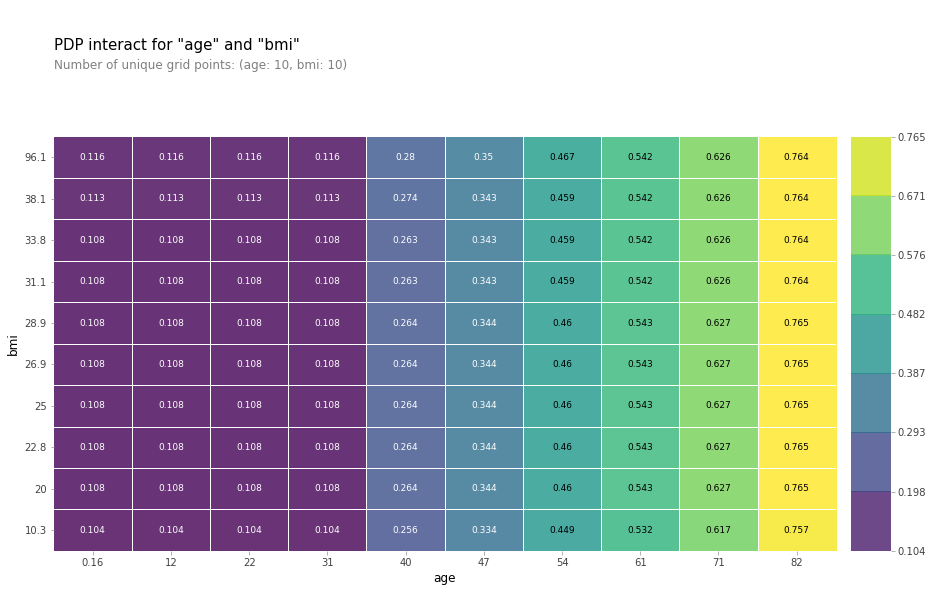

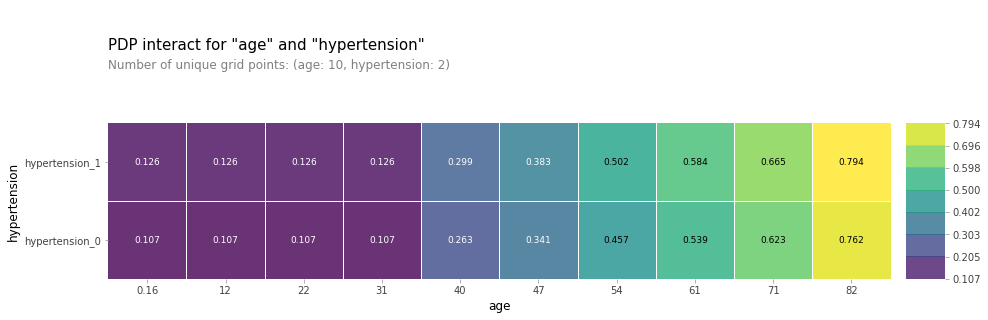

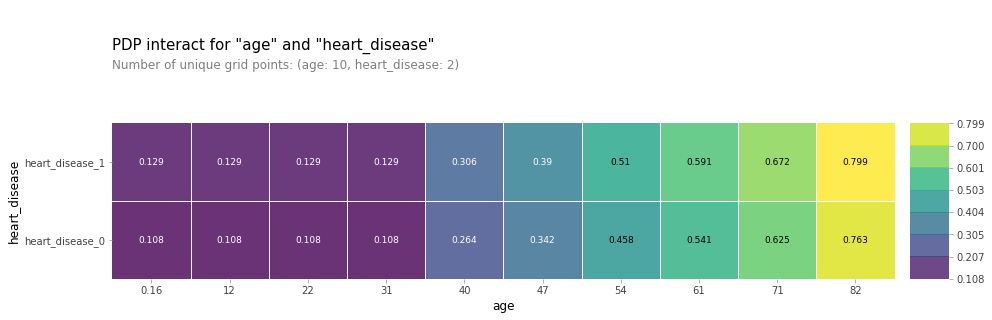

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

#---------------------------strok model---------------------------
features_list = [['age','bmi'],['age','hypertension'],['age','heart_disease']]

figsizes=[(15,10),(15,5),(15,5)]
for features,figsize in zip(features_list,figsizes):

  interaction = pdp_interact(
    model=best_model_XG_stroke, 
    dataset=X_test_stroke,
    model_features=X_test_stroke.columns, 
    features=features
  )

  pdp_interact_plot(interaction, plot_type='grid', 
                    feature_names=features,figsize=figsize);

age특성에 대해 건강정보를 가진 특성과의 연관도를 시각화해본 결과 위의 특성중요도에서 보인 결과를 재확인 할수 있었습니다.

건강정보를 가진 특성의 변화에 의한 예측영향도는 미미한 편이며, age특성의 변화에 따라 크게 바뀌는 것을 확인했습니다.

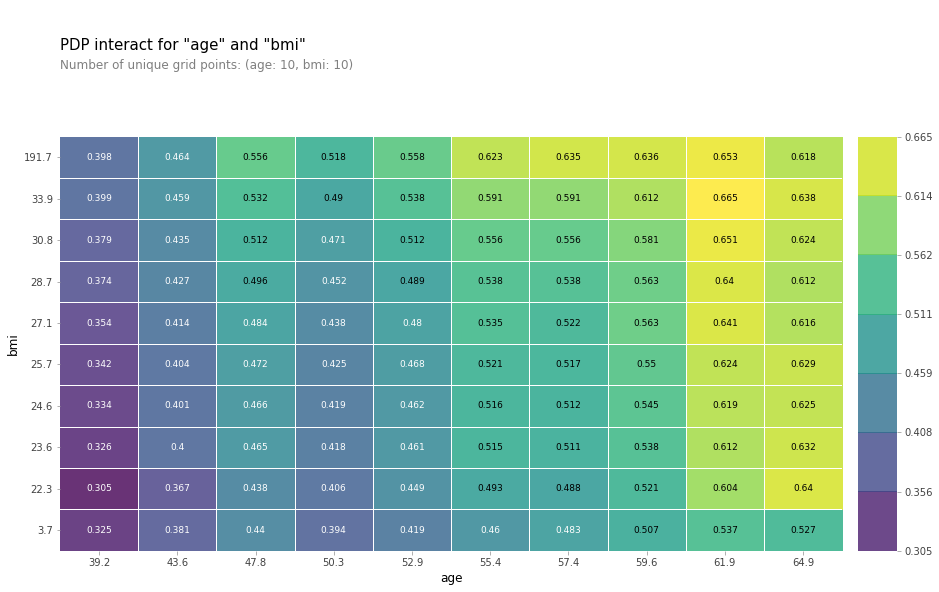

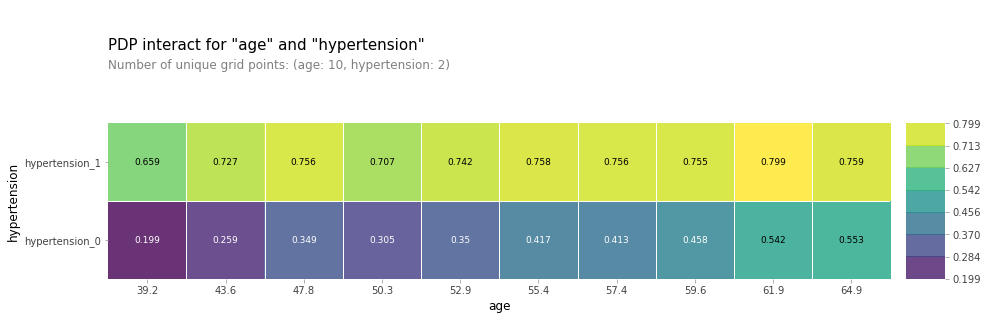

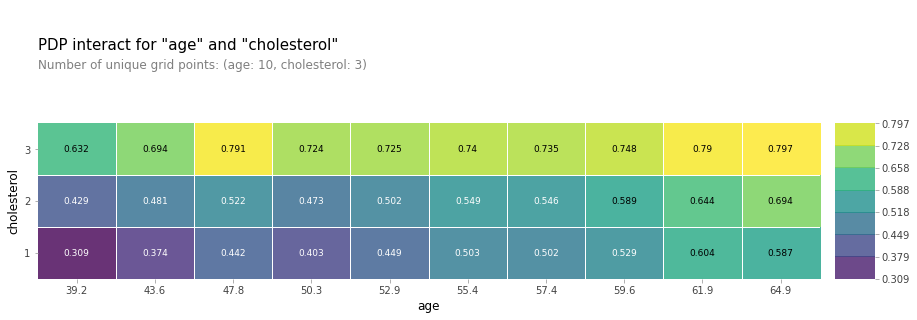

In [ ]:
features_list = [['age','bmi'],['age','hypertension'],['age','cholesterol']]
figsizes=[(15,10),(15,5),(15,5)]
for features,figsize in zip(features_list,figsizes):

  interaction = pdp_interact(
    model=best_model_XG_cardio, 
    dataset=X_test_cardio,
    model_features=X_test_cardio.columns, 
    features=features
  )

  pdp_interact_plot(interaction, plot_type='grid', 
                    feature_names=features,
                    figsize=figsize);

심장질환의 경우 나이에 따른 예측 확률과 건강정보에 의한 예측 확률 변화가 비슷한 것을 확인할수 있습니다.

그러므로 심장질환의 경우 건강정보 특성의 영향을 가장 크게 받는것으로 판단됩니다.

In [ ]:
!pip install shap

     |████████████████████████████████| 356 kB 5.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491646 sha256=f208d2c55ea8b147c7c4cbdde50330bc3753d9edb4460a3bde4c06c96363b918
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
from IPython.display import display
import shap

#---------------------------strok model shap---------------------------

row=[15052,16373,35666,12025]
for i in row:
  explainer = shap.TreeExplainer(best_model_XG_stroke)
  shap_values = explainer.shap_values(X_test_stroke.loc[i])

  shap.initjs()
  display(shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=X_test_stroke.loc[[i]],
    link='logit'
  ))

뇌졸중의 경우 나이특성이 가장큰 영향을 가지고 있으며 각 환자들의 예측 요인들을 확인해본 결과, 젊을 수록 신체건강 정보에 대해 작게 영향을 받지만 늙을수록 신체건강정보에 따른 뇌졸중 위험 확률이 올라가는것을 확인할 수 있었습니다.

In [ ]:
#---------------------------cardio model shap---------------------------

row=[17370,42609,29304,40009]
for i in row:
  explainer = shap.TreeExplainer(best_model_XG_cardio)
  shap_values = explainer.shap_values(X_test_cardio.loc[i])

  shap.initjs()
  display(shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=X_test_cardio.loc[[i]],
    link='logit'
  ))

심장질환 예측의 경우 나이 뿐만 아니라 고혈압 특성과 같이 건강정보를 가지고 있는 특성이 예측에 더 많은 영향을 행사하는 것을 확인할수 있었습니다.

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np

#뇌졸중 모델 임계값 조정 및 최종 모델 생성
y_pred_proba=best_model_XG_stroke.predict_proba(df_stroke.drop('stroke',axis=1))[:,1]
fpr, tpr, thresholds=roc_curve(df_stroke['stroke'],y_pred_proba)
optimal_idx=np.argmax(tpr-fpr)
best_threshold=thresholds[optimal_idx]

y_pred=y_pred_proba>0.43

print(classification_report(df_stroke['stroke'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.63      0.77     41288
           1       0.04      0.90      0.07       643

    accuracy                           0.64     41931
   macro avg       0.52      0.77      0.42     41931
weighted avg       0.98      0.64      0.76     41931



In [ ]:
#심장질환 모델 임계값 조정 및 최종 모델 생성
y_pred_proba=best_model_XG_cardio.predict_proba(X_test_cardio)[:,1]
fpr, tpr, thresholds=roc_curve(y_test_cardio,y_pred_proba)
optimal_idx=np.argmax(tpr-fpr)
best_threshold=thresholds[optimal_idx]
print('best_threshold:',best_threshold)
y_pred=y_pred_proba>best_threshold

print(classification_report(y_test_cardio, y_pred))

best_threshold: 0.523092
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      7004
           1       0.76      0.68      0.71      6996

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



최종적으로 임계값을 조정하여 활용방향에 대하여 관련 평가지표에 대한 성능 개선을 진행하였습니다.

심장질환 모델 : 정밀도(precision) 중시 모델

뇌졸중 모델 : 재현율(recall) 중시 모델

이렇게 하여 심장질환 모델의 경우 환자에 대하여 심장질환 발생위험을 76% 정밀도로 예측할수 있고, 

뇌졸중 모델의 경우 negative로 예측된 환자에 대하여 아주 낮은 발병 위험도(0.3%)를 제공합니다.